In [1]:
import seaborn as sns

# The New York Social Graph


[New York Social Diary](https://www.newyorksocialdiary.com/) provides a
fascinating lens onto New York's socially well-to-do.  The data forms a natural social graph for New York's social elite.  Take a look at this page of a recent [To Love Unconditionally](https://www.newyorksocialdiary.com/to-love-unconditionally/). 

You will notice the photos have carefully annotated captions labeling those that appear in the photos.  We can think of this as implicitly implying a social graph: there is a connection between two individuals if they appear in a picture together.

For this project, we will assemble the social graph from photo captions for parties.  Using this graph, we can make guesses at the most popular socialites, the most influential people, and the most tightly coupled pairs.

We will attack the project in three phases:
1. Get a list of all the photo pages to be analyzed. 
2. Get all captions in each party, Parse all of the captions and extract guests' names.
3. Assemble the graph, analyze the graph and answer the questions

## Phase One


The first step is to crawl the data.  We want photos from parties on or before December 1st, 2014.  Go to the [Party Pictures Archive](https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures) to see a list of (party) pages.  We want to get the url for each party page, along with its date.

Here are some packages that you may find useful.  You are welcome to use others, if you prefer.

In [3]:
import requests
import dill
from bs4 import BeautifulSoup
from datetime import datetime

We recommend using Python [Requests](http://docs.python-requests.org/en/master/) to download the HTML pages, and [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) to process the HTML.  Let's start by getting the [first page](https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures).

In [ ]:
url = "https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures"
page = requests.get(url) # Use requests.get to download the page.

Now, we process the text of the page with BeautifulSoup.

In [ ]:
# Step 1: Fetch the HTML content
url = 'http://example.com'  # Replace with your target URL
response = requests.get(url)
html_content = response.text

# Step 2: Parse the HTML content
soup = BeautifulSoup(html_content, 'html.parser')

# Step 3: Find the specific <div> (example using class)
div = soup.find('div', class_='specific-class')  # Replace 'specific-class' with the actual class name

# Step 4: Extract the link from the <div>
if div:
    link = div.find('a')  # Find the first <a> tag within the <div>
    if link and 'href' in link.attrs:
        href = link['href']
        print('Link:', href)
    else:
        print('No link found in the specified <div>.')
else:
    print('No <div> found with the specified class.')


In [ ]:
soup = BeautifulSoup(page.text, "lxml")


This page has links to 50 party pages. Look at the structure of the page and determine how to isolate those links.  Your browser's developer tools (usually `Cmd`-`Option`-`I` on Mac, `Ctrl`-`Shift`-`I` on others) offer helpful tools to explore the structure of the HTML page.

Once you have found a pattern, use BeautifulSoup's [select](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#css-selectors) or [find_all](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#find) methods to get those elements.

In [5]:
import time
import re

def filter_by_date(links, cutoff=datetime(2014, 12, 1)):
    filtered = []
    print(len(links))
    for link in links:
        url, date = link
        
        # Check if the URL and date exist and date is valid
        if date and url and (date[0] < cutoff.year or (date[0] <= cutoff.year and date[1] < cutoff.month) or (date[0] == cutoff.year and date[1] == cutoff.month and date[2] == cutoff.day)):
            filtered.append(link)
    
    return filtered

def convert_date(date_str):
    try:
        input_format = "%A, %B %d, %Y"
        date_obj = datetime.strptime(date_str, input_format)
        return date_obj.year, date_obj.month, date_obj.day
    except Exception as e:
        print(f"Error converting date '{date_str}': {e}")
        return None
    
def get_link_date(link):
    try:
        # Extract the URL from the title field
        titleField = link.find(class_="field-content")
        url = titleField.find("a")['href'] if titleField and titleField.find("a") else None
        pattern = r'^.*?(http)'
        cleaned_url = re.sub(pattern, r'\1', url) if url else None
        
        # Extract the date from the created field
        dateField = link.find(class_="views-field-created")
        date_str = dateField.find(class_="field-content").text if dateField else None
        
        # Convert the date string to a tuple (year, month, day)
        date = convert_date(date_str) if date_str else None
        
        return (url, date)
    except Exception as e:
        print(f"Error processing link: {e}")
        return (None, None)
def get_page_links(page_link):
    try:
        page = requests.get(page_link)
        soup = BeautifulSoup(page.text, "lxml")
        
        # Find all rows containing links and dates
        rows = soup.find_all(class_="views-row")
        
        # Store the (url, date) tuples
        links_and_dates = [get_link_date(row) for row in rows]
        
        return links_and_dates
    except Exception as e:
        print(f"Error fetching page {page_link}: {e}")
        return []
    

links = get_page_links("https://web.archive.org/web/20150918040703/http://www.newyorksocialdiary.com/party-pictures?page=1")
print(links)

[('/web/20150918040703/http://www.newyorksocialdiary.com/party-pictures/2015/bunny-hop-the-boys-club-old-bags-and-more', (2015, 3, 13)), ('/web/20150918040703/http://www.newyorksocialdiary.com/party-pictures/2015/sab-the-jewish-museum-roundabout-theatre-and-faces', (2015, 3, 11)), ('/web/20150918040703/http://www.newyorksocialdiary.com/party-pictures/2015/adaa-art-show-bronx-museum-the-china-arts-foundation-international-and-the-palm', (2015, 3, 5)), ('/web/20150918040703/http://www.newyorksocialdiary.com/party-pictures/2015/the-60th-anniversary-of-the-viennese-opera-ball-and-mcnys-directors-council', (2015, 3, 4)), ('/web/20150918040703/http://www.newyorksocialdiary.com/party-pictures/2015/the-new-york-philharmonic-the-new-york-botanical-garden-longhouse-reserve-and', (2015, 3, 2)), ('/web/20150918040703/http://www.newyorksocialdiary.com/party-pictures/2015/mission-accomplished', (2015, 2, 26)), ('/web/20150918040703/http://www.newyorksocialdiary.com/party-pictures/2015/philanthropic-

There should be 50 per page.

In [6]:
len(links) == 50

True

Let's take a look at that first link.  Figure out how to extract the URL of the link, as well as the date.  You probably want to use `datetime.strptime`.  See the [format codes for dates](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior) for reference.

In [ ]:
"/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2015/grand-finale-of-the-hampton-classic-horse-show">Grand Finale of the Hampton Classic Horse Show</a>

In [8]:
link = links[0]
# Check that the title and date match what you see visually.
link

('/web/20150918040703/http://www.newyorksocialdiary.com/party-pictures/2015/bunny-hop-the-boys-club-old-bags-and-more',
 (2015, 3, 13))

For purposes of code reuse, let's put that logic into a function.  It should take the link element and return the URL and date parsed from it.

In [ ]:
def get_link_date(el):
    ...
    return url, date

You may want to check that it works as you expected.

Once that's working, let's write another function to parse all of the links on a page.  Thinking ahead, we can make it take a Requests [Response](https://requests.readthedocs.io/en/master/api/#requests.Response) object and do the BeautifulSoup parsing within it.

In [ ]:
def get_links(response):
    return ... # A list of URL, date pairs

If we run this on the previous response, we should get 50 pairs.

In [ ]:
# These should be the same links from earlier
len(get_links(page)) == 50

But we only want parties with dates on or before the first of December, 2014.  Let's write a function to filter our list of dates to those at or before a cutoff.  Using a keyword argument, we can put in a default cutoff, but allow us to test with others.

In [ ]:
def filter_by_date(links, cutoff=datetime(2014, 12, 1)):
    # Return only the elements with date <= cutoff

With the default cutoff, there should be no valid parties on the first page.  Adjust the cutoff date to check that it is actually working.

In [ ]:
# Double check the dates are being extracted correctly
len(filter_by_date(get_links(page))) == 0

Now we should be ready to get all of the party URLs.  Click through a few of the index pages to determine how the URL changes.  Figure out a strategy to visit all of them.

HTTP requests are generally IO-bound.  This means that most of the time is spent waiting for the remote server to respond.  If you use `requests` directly, you can only wait on one response at a time.  [requests-futures](https://github.com/ross/requests-futures) lets you wait for multiple requests at a time.  You may wish to use this to speed up the downloading process.

In [ ]:
from requests_futures.sessions import FuturesSession

link_list = []
# You can use link_list.extend(others) to add the elements of others
# to link_list.

In the end, you should have 1193 parties.

In [ ]:
# Make sure you are using the same /web/stringofdigits/... for each page
# This is to prevent the archive from accessing later copies of the same page
# If you are off by a just a few, that can be the archive misbehaving
len(link_list) == 1193

In case we need to restart the notebook, we should save this information to a file.  There are many ways you could do this; here's one using `dill`.

In [ ]:
dill.dump(link_list, open('nysd-links.pkd', 'wb'))

To restore the list, we can just load it from the file.  When the notebook is restarted, you can skip the code above and just run this command.

In [ ]:
link_list = dill.load(open('nysd-links.pkd', 'rb'))

### Question 1: In which month did most of the parties occur? (10 p)
### Question 2: What is the overall trend of parties from 2007 to 2014? (10 p)
Use visualizations to answer the two questions above. Ensure that you interpret your plots thoroughly.

## Phase Two


In this phase, we concentrate on getting the names out of captions for a given page.  We'll start with [the benefit cocktails and dinner](https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2015/celebrating-the-neighborhood) for [Lenox Hill Neighborhood House](http://www.lenoxhill.org/), a neighborhood organization for the East Side.

Take a look at that page.  Note that some of the text on the page is captions, but others are descriptions of the event.  Determine how to select only the captions.

In [ ]:
captions = ...

By our count, there are about 110.  But if you're off by a couple, you're probably okay.

In [ ]:
# These are for the specific party referenced in the text
abs(len(captions) - 110) < 5

Let's encapsulate this in a function.  As with the links pages, we want to avoid downloading a given page the next time we need to run the notebook.  While we could save the files by hand, as we did before, a checkpoint library like [ediblepickle](https://pypi.python.org/pypi/ediblepickle/1.1.3) can handle this for you.  (Note, though, that you may not want to enable this until you are sure that your function is working.)

You should also keep in mind that HTTP requests fail occasionally, for transient reasons.  You should plan how to detect and react to these failures.   The [retrying module](https://pypi.python.org/pypi/retrying) is one way to deal with this.

In [ ]:
def get_captions(path):
    ...

This should get the same captions as before.

In [ ]:
# This cell is expecting get_captions to return a list of the captions themselves
# Other routes to a solution might need to adjust this cell a bit
captions == get_captions("/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2015/celebrating-the-neighborhood")

Now that we have some sample captions, let's start parsing names out of those captions.  There are many ways of going about this, and we leave the details up to you.  Some issues to consider:

  1. Some captions are not useful: they contain long narrative texts that explain the event.  Try to find some heuristic rules to separate captions that are a list of names from those that are not.  A few heuristics include:
    - look for sentences (which have verbs) and as opposed to lists of nouns. For example, [`nltk` does part of speech tagging](http://www.nltk.org/book/ch05.html) but it is a little slow. There may also be heuristics that accomplish the same thing.
    - Similarly, spaCy's [entity recognition](https://spacy.io/docs/usage/entity-recognition) could be useful here.
    - Look for commonly repeated threads (e.g. you might end up picking up the photo credits or people such as "a friend").
    - Long captions are often not lists of people.  The cutoff is subjective, but for grading purposes, *set that cutoff at 250 characters*.
  2. You will want to separate the captions based on various forms of punctuation.  Try using `re.split`, which is more sophisticated than `string.split`. **Note**: Use regex exclusively for name parsing.
  3. This site is pretty formal and likes to say things like "Mayor Michael Bloomberg" after his election but "Michael Bloomberg" before his election.  Can you find other titles that are being used?  They should probably be filtered out because they ultimately refer to the same person: "Michael Bloomberg."
  4. There is a special case you might find where couples are written as eg. "John and Mary Smith". You will need to write some extra logic to make sure this properly parses to two names: "John Smith" and "Mary Smith".
  5. When parsing names from captions, it can help to look at your output frequently and address the problems that you see coming up, iterating until you have a list that looks reasonable. Because we can only asymptotically approach perfect identification and entity matching, we have to stop somewhere.
  
**Questions worth considering:**
  1. Who is Patrick McMullan and should he be included in the results? How would you address this?
  2. What else could you do to improve the quality of the graph's information?

Once you feel that your algorithm is working well on these captions, parse all of the captions and extract all the names mentioned.  

Now, run this sort of test on a few other pages.  You will probably find that other pages have a slightly different HTML structure, as well as new captions that trip up your caption parser.  But don't worry if the parser isn't perfect -- just try to get the easy cases.

Once you are satisfied that your caption scraper and parser are working, run this for all of the pages.  If you haven't implemented some caching of the captions, you probably want to do this first.

In [ ]:
# Scraping all of the pages could take 10 minutes to an hour

## Phase 3: Graph Analysis

For the remaining analysis, we think of the problem in terms of a
[network](http://en.wikipedia.org/wiki/Computer_network) or a
[graph](https://en.wikipedia.org/wiki/Graph_%28discrete_mathematics%29).  Any time a pair of people appear in a photo together, that is considered a link.  It is an example of  an **undirected weighted graph**. We recommend using python's [`networkx`](https://networkx.github.io/) library.

In [ ]:
import itertools  # itertools.combinations may be useful
import networkx as nx

All in all, you should end up with over 100,000 captions and more than 110,000 names, connected in about 200,000 pairs.

In [13]:
import os
import sys
import time
import itertools
import pandas as pd
import numpy as np
import igraph as ig

def get_full_filepath(filename):
    """
    Returns the full file path of the given filename located in the same directory as this script.
    """
    current_dir = os.path.dirname(os.path.abspath(filename))
    filepath = os.path.join(current_dir, filename)
    return filepath

def load_captions(filename):
    """
    Load the captions from a file and return as a list of lists of names.
    Adjusted to handle the actual format of 'passed.txt'.
    """
    filepath = get_full_filepath(filename)
    captions = []
    current_caption = []
    with open(filepath, 'r', encoding='utf-8') as file:
        for line in file:
            line = line.strip()
            if line == '':
                if current_caption:
                    captions.append(current_caption)
                    current_caption = []
            else:
                current_caption.append(line)
        # Add the last caption if any
        if current_caption:
            captions.append(current_caption)
    return captions

def build_igraph_incrementally(filename):
    """
    Builds an undirected weighted graph using igraph by processing captions incrementally.
    """
    filepath = filename#get_full_filepath(filename)
    # Create a mapping from names to indices to avoid storing names multiple times
    name_to_index = {}
    index_counter = 0
    edge_weights = {}
    
    with open(filepath, 'r', encoding='utf-8') as file:
        current_caption = []
        for line_num, line in enumerate(file):
            line = line.strip()
            if line == '':
                if len(current_caption) > 1:
                    # Process the current caption
                    indices = []
                    for name in current_caption:
                        if name not in name_to_index:
                            name_to_index[name] = index_counter
                            index_counter += 1
                        indices.append(name_to_index[name])
                    for u, v in itertools.combinations(indices, 2):
                        edge = (min(u, v), max(u, v))
                        if edge in edge_weights:
                            edge_weights[edge] += 1
                        else:
                            edge_weights[edge] = 1
                elif len(current_caption) == 1:
                    # Handle single names
                    name = current_caption[0]
                    if name not in name_to_index:
                        name_to_index[name] = index_counter
                        index_counter += 1
                current_caption = []
            else:
                current_caption.append(line)
        # Process the last caption
        if current_caption:
            if len(current_caption) > 1:
                indices = []
                for name in current_caption:
                    if name not in name_to_index:
                        name_to_index[name] = index_counter
                        index_counter += 1
                    indices.append(name_to_index[name])
                for u, v in itertools.combinations(indices, 2):
                    edge = (min(u, v), max(u, v))
                    if edge in edge_weights:
                        edge_weights[edge] += 1
                    else:
                        edge_weights[edge] = 1
            elif len(current_caption) == 1:
                # Handle single names
                name = current_caption[0]
                if name not in name_to_index:
                    name_to_index[name] = index_counter
                    index_counter += 1
    # Build the graph
    num_nodes = index_counter
    edges = list(edge_weights.keys())
    weights = list(edge_weights.values())
    G = ig.Graph()
    G.add_vertices(num_nodes)
    if edges:
        G.add_edges(edges)
        G.es['weight'] = weights
    else:
        G.es['weight'] = []
    # Assign names to vertices
    index_to_name = {index: name for name, index in name_to_index.items()}
    G.vs['name'] = [index_to_name[i] for i in range(num_nodes)]
    return G

def compute_graph_statistics(G):
    """
    Computes graph statistics: number of nodes, number of edges, diameter, average clustering coefficient.
    """
    num_nodes = G.vcount()
    num_edges = G.ecount()
    # Diameter calculation
    if G.is_connected():
        diameter = G.diameter()
    else:
        # Use the largest connected component
        largest_cc = G.clusters().giant()
        diameter = largest_cc.diameter()
    # Average clustering coefficient
    avg_clustering_coeff = G.transitivity_undirected()
    graph_stats = {
        "num_nodes": num_nodes,
        "num_edges": num_edges,
        "diameter": diameter,
        "avg_clustering_coeff": avg_clustering_coeff
    }
    return graph_stats

def get_most_photogenic(G, top_n=100):
    """
    Returns the top_n people with the highest weighted degree (most photogenic).
    """
    degrees = G.strength(weights='weight')
    names = G.vs['name']
    weighted_degree = list(zip(names, degrees))
    top_photogenic = sorted(weighted_degree, key=lambda x: x[1], reverse=True)[:top_n]
    return top_photogenic

def compute_centrality_measures(G, top_n=10):
    """
    Computes various centrality measures and returns the top_n individuals for each measure.
    """
    # Ensure the graph is connected or use the largest connected component
    if not G.is_connected():
        G = G.clusters().giant()
    
    names = G.vs['name']
    
    # Eccentricity centrality
    eccentricity = G.eccentricity()
    top_eccentricity = sorted(zip(names, eccentricity), key=lambda x: x[1])[:top_n]  # Lower is better
    
    # Closeness centrality
    closeness = G.closeness(weights='weight')
    top_closeness = sorted(zip(names, closeness), key=lambda x: x[1], reverse=True)[:top_n]
    
    # Betweenness centrality
    betweenness = G.betweenness(weights='weight')
    top_betweenness = sorted(zip(names, betweenness), key=lambda x: x[1], reverse=True)[:top_n]
    
    # Eigenvector centrality (prestige)
    eigenvector = G.eigenvector_centrality(weights='weight')
    top_eigenvector = sorted(zip(names, eigenvector), key=lambda x: x[1], reverse=True)[:top_n]
    
    # PageRank
    pagerank = G.pagerank(damping=0.85, weights='weight')
    top_pagerank = sorted(zip(names, pagerank), key=lambda x: x[1], reverse=True)[:top_n]
    
    centrality_measures = {
        'eccentricity': top_eccentricity,
        'closeness': top_closeness,
        'betweenness': top_betweenness,
        'eigenvector': top_eigenvector,
        'pagerank': top_pagerank
    }
    return centrality_measures

def get_top_edges(G, top_n=100):
    """
    Returns the top_n edges with the highest weights.
    """
    edges = G.get_edgelist()
    weights = G.es['weight']
    edge_list = [(G.vs[u]['name'], G.vs[v]['name'], w) for (u, v), w in zip(edges, weights)]
    top_edges = sorted(edge_list, key=lambda x: x[2], reverse=True)[:top_n]
    return top_edges

## Question 3: Graph EDA (20 p)


In [5]:
import networkx as nx

G = nx.Graph()
edge_weights = {}

# Open and process the file line by line
with open('code/passed.txt', 'r') as f:
    for line in f:
        names = [name.strip() for name in line.split(',') if name.strip()]  # Split names and strip spaces
        
        # Add edges between every pair of names in the same line
        for i in range(len(names)):
            for j in range(i + 1, len(names)):
                edge = (names[i], names[j])
                
                # Update the weight for the edge
                if edge in edge_weights:
                    edge_weights[edge] += 1
                else:
                    edge_weights[edge] = 1

# Add edges to the graph with their corresponding weights
for (u, v), weight in edge_weights.items():
    G.add_edge(u, v, weight=weight)


In [6]:
import matplotlib.pyplot as plt
def visualize_graph(G):
    """
    Visualizes the graph using a spring layout.
    For large graphs, it visualizes a subgraph of up to 100 nodes.
    """
    # Visualize a subgraph if the graph is too large
    subgraph = G
    if G.number_of_nodes() > 100:
        # Largest connected component
        largest_cc = max(nx.connected_components(G), key=len)
        subgraph = G.subgraph(largest_cc)
        # Limit to 100 nodes
        if subgraph.number_of_nodes() > 100:
            subgraph = subgraph.subgraph(list(subgraph.nodes())[:100])

    pos = nx.spring_layout(subgraph)

    # Draw nodes and edges
    nx.draw_networkx_nodes(subgraph, pos, node_size=300, node_color='lightblue')
    nx.draw_networkx_edges(subgraph, pos, width=1.0, alpha=0.5, edge_color='gray')
    nx.draw_networkx_labels(subgraph, pos, font_size=8)

    # Add edge weights as labels
    edge_labels = {(u, v): d['weight'] for u, v, d in subgraph.edges(data=True)}
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=6)

    plt.title("Graph Visualization")
    plt.axis('off')
    plt.show()

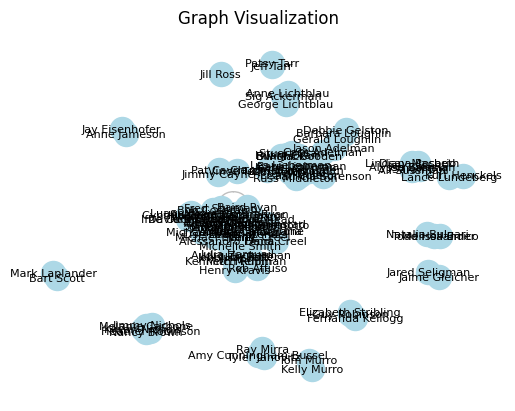

In [7]:
visualize_graph(G)

In [10]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
avg_clustering_coeff = nx.average_clustering(G)

print(num_nodes)
print(num_edges)
print(avg_clustering_coeff)

86129
164136
0.49049404440378813


In [ ]:
# Diameter calculation (only for connected components)
if nx.is_connected(G):
    diameter = nx.diameter(G)
else:
    # Use the largest connected component
    largest_cc = max(nx.connected_components(G), key=len)
    subgraph = G.subgraph(largest_cc)
    diameter = nx.diameter(subgraph)

- Use parsed names to create the undirected weighted network and visualize it (5 p)
- Report the number of nodes and edges (5 p)
Number of nodes is 86129 and edges 164136
- What is the diameter of this graph? (5 p)
Calculated Diameter is 21 for the largest connected subgraph
- What is the average clustering coeff of the graph? How you interpret this number? (5 p)
0.49049404440378813 is the average clustering coeff. As we know that clustering coefficient is between 0 and 1. With 0 meaning no clustering at all and 1 being a very good cluster with every neightbor of the node being interconnected. 0.49 represents that around 49% of valid connections of node's neightbors are real connections of the graph.

## Question 4: Graph properties (20 p)

What real-world graph properties does this graph exhibit? Please show your work and interpret your answer. Does the result make sense given the nature of the graph?

## Question 4: Who are the most photogenic persons? (10 p)

The simplest question to ask is "who is the most popular"?  The easiest way to answer this question is to look at how many connections everyone has.  Return the top 100 people and their degree.  Remember that if an edge of the graph has weight 2, it counts for 2 in the degree.

**Checkpoint:** Some aggregate stats on the solution

    "count": 100.0
    "mean": 189.92
    "std": 87.8053034454
    "min": 124.0
    "25%": 138.0
    "50%": 157.0
    "75%": 195.0
    "max": 666.0

In [13]:
def get_most_photogenic(G, top_n=100):
    """
    Returns the top_n people with the highest weighted degree (most photogenic).
    """
    # Compute weighted degrees
    weighted_degree = dict(G.degree(weight='weight'))

    # Sort by weighted degree in descending order and take the top N
    top_photogenic = sorted(weighted_degree.items(), key=lambda x: x[1], reverse=True)[:top_n]
    
    return top_photogenic

In [14]:
import pandas as pd
top_photogenic = get_most_photogenic(G)
# Display the top 100 people and their degrees
df_photogenic = pd.DataFrame(top_photogenic, columns=['Person', 'Weighted Degree'])
print("Top 100 Most Photogenic Persons:")
print(df_photogenic.to_string(index=False))
    

NameError: name 'pd' is not defined

In [ ]:
# Compute aggregate statistics for the checkpoint
stats_photogenic = df_photogenic['Weighted Degree'].describe()
print("\nAggregate statistics for the top 100 most photogenic persons:")
print(stats_photogenic)

## Question 5: Centrality analysis (20 p)


Use eccentricity centrality, closeness centrality, betweenness centrality, prestige, and PageRank to identify the top 10 individuals with the highest centrality for each measure. How do you interpret the results?

Use 0.85 as the damping parameter for page rank, so that there is a 15% chance of jumping to another vertex at random.

**Checkpoint:** Some aggregate stats on the solution for pagerank

    "count": 100.0
    "mean": 0.0001841088
    "std": 0.0000758068
    "min": 0.0001238355
    "25%": 0.0001415028
    "50%": 0.0001616183
    "75%": 0.0001972663
    "max": 0.0006085816

## Question 6: best_friends (10 p)


Another interesting question is who tend to co-occur with each other.  Give us the 100 edges with the highest weights.

Google these people and see what their connection is.  Can we use this to detect instances of infidelity?

**Checkpoint:** Some aggregate stats on the solution

    "count": 100.0
    "mean": 25.84
    "std": 16.0395470855
    "min": 14.0
    "25%": 16.0
    "50%": 19.0
    "75%": 29.25
    "max": 109.0

In [32]:
import pandas as pd

top_edges = get_top_edges(G)
df_edges = pd.DataFrame(top_edges, columns=['Person1', 'Person2', 'Weight'])
print("Top 100 Edges with Highest Weights:")
print(df_edges.to_string(index=False))
# Compute aggregate statistics for the checkpoint
stats_edges = df_edges['Weight'].describe()
print("\nAggregate statistics for the top 100 edges:")
print(stats_edges)